The following connects to the Google Drive where I have Networkx and Pytorch Geometric installed:

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive/')

nb_path = '/content/notebooks'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
sys.path

['/content/notebooks',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

Alternatively, install the modules:

In [ ]:
!pip install torch_geometric
!pip install networkx

Import modules:

In [ ]:
import torch
import networkx as nx
import torch_geometric as geo
from torch_geometric.data import Dataset, DataLoader, Data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

Create dataset and edge indices:

In [ ]:
graphs = []
num_graphs = 500
num_node_features = 100
feature_matrices = []
adj_matrices = []

for i in range(num_graphs):
  g = nx.Graph()
  features = []

  #add random number of nodes
  num_nodes = 5

  for n in range(num_nodes):
    feature = torch.tensor(np.random.randn(1, num_node_features), dtype=torch.float32)
    features.append(feature)
    g.add_node(n, feature=feature)
  for e in range(np.random.randint(num_nodes+1, 3*num_nodes)):
    g.add_edge(np.random.randint(0,num_nodes), np.random.randint(0,num_nodes))

  graphs.append(g)
  feature_matrices.append(torch.cat(features, dim=0))
  adj_matrices.append(torch.tensor(nx.to_numpy_array(g), dtype=torch.float32))

#Create edge_indices

edge_indices = []
for i, graph in enumerate(graphs):
  adj_matrix = adj_matrices[i]
  edge_index = geo.utils.dense_to_sparse(adj_matrix)[0]
  edge_indices.append(edge_index)

Since our model takes in batches of data, create a Dataloader:

In [ ]:
dataset = []
for i in range(len(graphs)):
  dataset.append(Data(x=feature_matrices[i], edge_index=edge_indices[i]))
train_loader = DataLoader(dataset[:4900], batch_size=1)
test_loader = DataLoader(dataset[4900:], batch_size=1)

/content/notebooks/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Define model with permutation invariant global pooling layer:

In [ ]:
model = geo.nn.Sequential('x, edge_index, batch',[
        (geo.nn.GCNConv(100, 25), 'x, edge_index -> x'),
        nn.ReLU(inplace=True),
        (geo.nn.GCNConv(25,25), 'x, edge_index -> x'),
        nn.ReLU(inplace=True),
        (geo.nn.GCNConv(25,25), 'x, edge_index -> x'),
        nn.ReLU(inplace=True),
        (geo.nn.GCNConv(25,25), 'x, edge_index -> x'),
        nn.ReLU(inplace=True),
        (geo.nn.GCNConv(25,20), 'x, edge_index -> x'),
        nn.ReLU(inplace=True),
        (geo.nn.global_max_pool, 'x, batch -> x'),
])

Define a function that performs permutations on the input feature matrix, the adjacency matrix, and the edge index.

In [ ]:
import random
def random_permutation(feature_matrix, adj_matrix, edge_index):
  num_nodes = feature_matrix.shape[0]
  num_edges = edge_index.shape[1]
  perm = [i for i in range(num_nodes)]
  random.shuffle(perm)
  #print(perm)
  new_feature_matrix = feature_matrix[perm]
  new_adj_matrix = adj_matrix[perm]
  new_adj_matrix = torch.index_select(new_adj_matrix, 1, torch.LongTensor(perm))
  #print(edge_index)
  new_edge_index = geo.utils.dense_to_sparse(new_adj_matrix)[0]
  #print(new_edge_index)
  return new_feature_matrix, new_adj_matrix, new_edge_index

Visualize the effect of permutation (reordering nodes) on a graph and check that they are isomorphic:

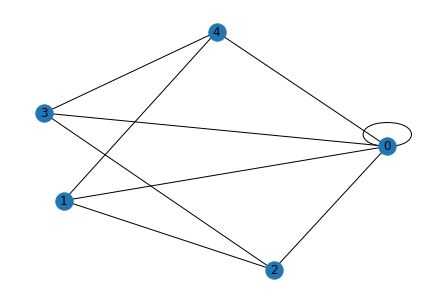

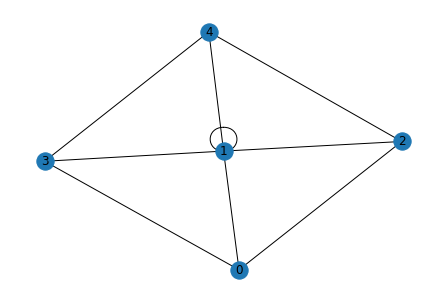

In [ ]:
i = 123
g1 = graphs[i]
new_feature_matrix, new_adj_matrix, new_edge_index = random_permutation(feature_matrices[i], adj_matrices[i], edge_indices[i])
g2 = nx.from_numpy_matrix(np.array(new_adj_matrix))
plt.figure(1)
nx.draw(g1, with_labels=True)
plt.figure(2)
nx.draw(g2, with_labels=True)

Iterate through the dataset to check that the resultant feature vectors are permutation invariant.

In [ ]:
for i, data in enumerate(train_loader):
  feature_embedding = model(data.x, edge_indices[i], data.batch)
  new_feature_matrix, new_adj_matrix, new_edge_index = random_permutation(data.x, adj_matrices[i], edge_indices[i])

  feature_embedding_after_permutation = model(new_feature_matrix, new_edge_index, data.batch)
  
  assert torch.linalg.norm(feature_embedding_after_permutation - feature_embedding) < 1e-5

print('Success!')

Success!
